# Image of an accretion disk around a Schwarzschild black hole

This [Jupyter/SageMath](https://www.sagemath.org/) notebook is relative to the lectures
[Geometry and physics of black holes](https://relativite.obspm.fr/blackholes/).

In [1]:
version()

'SageMath version 9.1.beta8, Release Date: 2020-03-18'

In [2]:
%display latex

### Function $\Phi_b(u)$

We evaluate $\Phi_b(u)$ via the functions [elliptic_f](https://doc.sagemath.org/html/en/reference/functions/sage/functions/special.html?highlight=elliptic_f#sage.functions.special.EllipticF) and [elliptic_kc](https://doc.sagemath.org/html/en/reference/functions/sage/functions/special.html?highlight=elliptic_f#sage.functions.special.EllipticKC) of SageMath, taking into account that the second argument of `elliptic_f` and the argument of `elliptic_kc` is $m = k^2$ and not $k$.

In [3]:
def Phi(u, b):
    u = RDF(u)
    b = RDF(b)
    bc = RDF(3*sqrt(3))
    if b > bc: 
        xi = 2*arcsin(bc/b)/3
        un = RDF(1/3*cos(xi + 2*pi/3) + 1/6)
        up = RDF(1/3*cos(xi + 4*pi/3) + 1/6)
        ua = RDF(1/3*cos(xi) + 1/6)
        k2 = (up - un)/(ua - un)
        phi = arcsin(sqrt((u - un)/(up - un)))
        # NB: elliptic_kc() and elliptic_f() takes m=k^2 as argument
        aa = elliptic_kc(k2) - elliptic_f(phi, k2)
        return sqrt(2/(ua - un)) * aa
    else:
        xi = bc/b - sqrt((bc/b)^2 - 1)
        un = (1 - xi^(2/3) - xi^(-2/3))/6
        us = sqrt(un*(3*un - 1)) + un
        k2 = (us - 2.5*un + 0.25)/(2*(us - un))
        phi = arccos(abs(us - u)/(us + u - 2*un))
        # NB: elliptic_kc() take m=k^2 as argument
        aa = elliptic_kc(k2) - elliptic_f(phi, k2)
        if u > us:
            aa = - aa
        return aa / sqrt(2*(us - un))            

### Asymptotic direction $\varphi_\infty$ from some emission point

In [4]:
def phi_infinity(r_em, b, phi_em=0, pre_periastron=True, eps_L=1):
    # print("r_em: {}, b: {}".format(r_em, b))
    u_em = RDF(1)/RDF(r_em)
    b = RDF(b)
    bc = RDF(3*sqrt(3))
    phi_em = RDF(phi_em)
    if b > bc: 
        if pre_periastron:
            return phi_em + eps_L*(Phi(0, b) + Phi(u_em, b))
        return phi_em + eps_L*(Phi(0, b) - Phi(u_em, b))
    return phi_em + eps_L*(Phi(0, b) - Phi(u_em, b))

In [5]:
phi_infinity(6., 5.2, phi_em=pi/2, pre_periastron=False)

2.5472182273726496

### Value of $b$ for a given $(\varphi_\infty, r_{\rm em}, \varphi_{\rm em})$

In [6]:
def find_b(phi_inf, r_em, phi_em, pre_periastron=True):
    phi_inf = RDF(phi_inf)
    r_em = RDF(r_em)
    phi_em = RDF(phi_em)
    bmax = 0.999*sqrt(r_em**3 / (r_em - RDF(2)))
    eps_L = 1 if phi_inf > phi_em else -1
    bc1 = 1.0000001*RDF(3*sqrt(3))
    def delta_phi(b):
        return phi_infinity(r_em, b, phi_em=phi_em, 
                            pre_periastron=pre_periastron, 
                            eps_L=eps_L) - phi_inf
    return find_root(delta_phi, bc1, bmax)

In [7]:
find_b(0, 6., pi/2, pre_periastron=False)

6.932148479189469

In [8]:
find_b(2*pi, 6., pi/2, pre_periastron=True)

5.478913722083879

In [9]:
find_b(-2*pi, 6., pi/2, pre_periastron=True)

5.207989587554517

### $\varphi$ as a function of $r$ along a null geodesic parametrized by $(r_{\rm em}, \varphi_{\rm em}, b)$

In [10]:
def phi_sol(r, r_em, phi_em, b, em_pre_periastron=True, 
            pre_periastron=True, eps_L=1):
    u = RDF(1)/RDF(r)
    u_em = RDF(1)/RDF(r_em)
    phi_em = RDF(phi_em)
    if em_pre_periastron:
        if pre_periastron:
            return phi_em + eps_L*(Phi(u_em, b) - Phi(u, b))
        return phi_em + eps_L*(Phi(u_em, b) + Phi(u, b))
    return phi_em + eps_L*(Phi(u, b) - Phi(u_em, b))

In [11]:
phi_sol(7, 6, pi/2, 6.93)

1.1962212307131173

### Periastron as a function of $b$

In [12]:
def r_periastron(b):
    return RDF(2/sqrt(3)*b*cos(pi/3 - arccos(3*sqrt(3)/b)/3))

In [13]:
r_periastron(3*sqrt(3))

3.0

In [14]:
r_periastron(6), r_periastron(10)

(4.453363193811356, 8.78885066249973)

## Computation of null geodesics

In [15]:
def geod(r_em, phi_em, b, eps_L, em_pre_periastron=True, rmax=25, np=500):
    resu = []
    if em_pre_periastron:
        rp = 1.001*r_periastron(b)
        if r_em < rp:
            raise ValueError("r_em < r_per(b)")
        dr = RDF(r_em - rp)/RDF(np - 1)
        for i in range(np):
            r = r_em - i*dr
            phi = phi_sol(r, r_em, phi_em, b, em_pre_periastron=True,
                  pre_periastron=True, eps_L=eps_L)
            resu.append((RDF(r)*cos(phi), RDF(r)*sin(phi)))
        #
        np = 2*np
        dr = RDF(rmax - rp)/RDF(np - 1)
        for i in range(np):
            r = rp + i*dr
            phi = phi_sol(r, r_em, phi_em, b, em_pre_periastron=True,
                  pre_periastron=False, eps_L=eps_L)
            resu.append((RDF(r)*cos(phi), RDF(r)*sin(phi)))
    else:
        dr = RDF(rmax - r_em)/RDF(np - 1)
        for i in range(np):
            r = r_em + i*dr
            phi = phi_sol(r, r_em, phi_em, b, em_pre_periastron=False,
                  pre_periastron=False, eps_L=eps_L)
            resu.append((RDF(r)*cos(phi), RDF(r)*sin(phi)))
    return resu

Inner and outer radii of the accretion disk:

In [16]:
r_disk_in = 6
r_disk_out = 9

Colors of the various images:

In [17]:
color1 = 'orange'
color2 = 'peru'
color3 = 'red'

### Emission from the upper part of the disk ($\varphi_{\rm em} = \pi/2$)

In [18]:
phi_em = pi/2

In [19]:
r_em = r_disk_in

In [20]:
em_pre_periastron = False

In [21]:
b1_in = find_b(0, r_em, phi_em, pre_periastron=em_pre_periastron)
b1_in

6.932148479189469

In [22]:
eps_L = -1

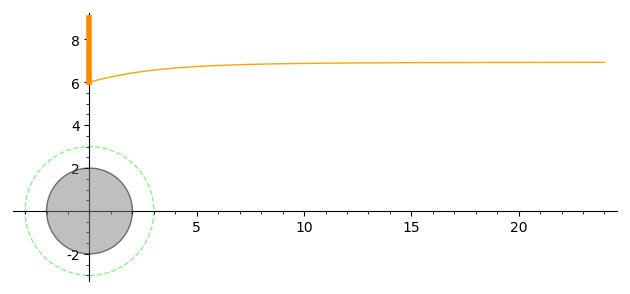

In [23]:
graph = circle((0, 0), 2, edgecolor='black', fill=True, facecolor='grey', alpha=0.5)
graph += circle((0, 0), 3, color='lightgreen', thickness=1., linestyle='--', zorder=1)
graph += line([(0, r_disk_in), (0, r_disk_out)], color='darkorange', 
              thickness=4, zorder=50)
graph += line(geod(r_em, phi_em, b1_in, eps_L, em_pre_periastron=em_pre_periastron), 
              color=color1)
graph

In [24]:
em_pre_periastron = True

In [25]:
b2_in = find_b(2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
b2_in

5.478913722083879

In [26]:
eps_L = 1

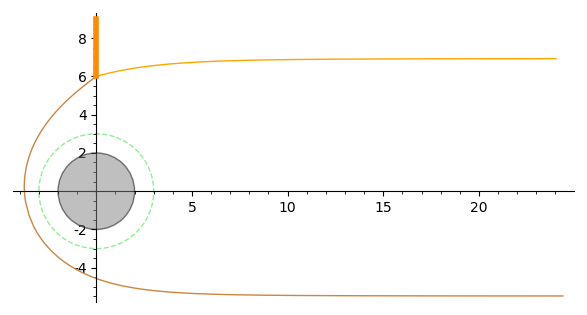

In [27]:
graph += line(geod(r_em, phi_em, b2_in, eps_L, em_pre_periastron=em_pre_periastron),
              color=color2)
graph

In [28]:
eps_L = -1

In [29]:
b3_in = find_b(-2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
b3_in

5.207989587554517

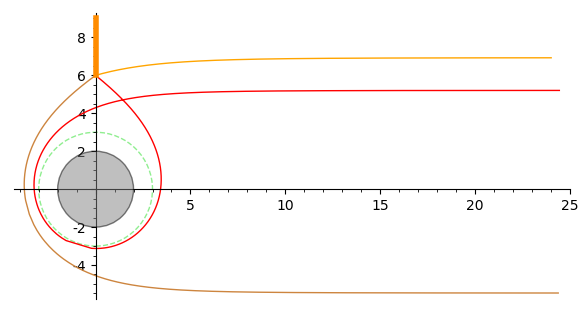

In [30]:
graph += line(geod(r_em, phi_em, b3_in, eps_L, em_pre_periastron=em_pre_periastron,
                   np=4000), color=color3)
graph

In [31]:
r_em = r_disk_out

In [32]:
em_pre_periastron = False
b1_out = find_b(0, r_em, phi_em, pre_periastron=em_pre_periastron)
eps_L = -1
graph += line(geod(r_em, phi_em, b1_out, eps_L, em_pre_periastron=em_pre_periastron), 
              color=color1)

In [33]:
em_pre_periastron = True
eps_L = 1
b2_out = find_b(2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b2_out, eps_L, em_pre_periastron=em_pre_periastron),
              color=color2)

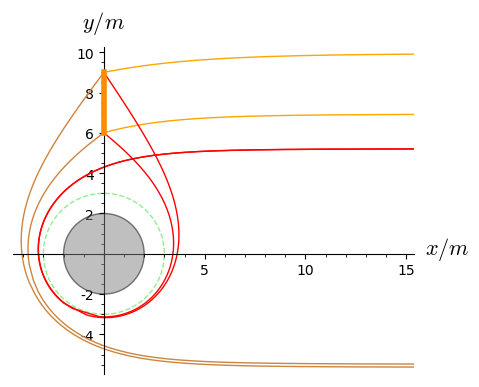

In [34]:
eps_L = -1
b3_out = find_b(-2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b3_out, eps_L, em_pre_periastron=em_pre_periastron,
                   np=4000), color=color3)
show(graph, xmax=15, axes_labels=[r'$x/m$', r'$y/m$'])

In [35]:
graph.save("gis_disk_image_detail.pdf", xmax=15, 
           axes_labels=[r'$x/m$', r'$y/m$'])

Inner radius and width of primary image:

In [36]:
b1_in, b1_out - b1_in

(6.932148479189469, 3.0197242048926336)

Inner radius and width of secondary image:

In [37]:
b2_in, b2_out - b2_in

(5.478913722083879, 0.15113581710277924)

Inner radius and width of tertiary image:

In [38]:
b3_in, b3_out - b3_in

(5.207989587554517, 0.005314937250211926)

### Emission from the lower part of the disk ($\varphi_{\rm em} = 3\pi/2$)

In [39]:
phi_em = 3*pi/2

In [40]:
r_em = r_disk_in

In [41]:
em_pre_periastron = False
b = find_b(2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
eps_L = 1
graph += line([(0, -r_disk_in), (0, -r_disk_out)], color='darkorange', 
              thickness=4, zorder=50)
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron), 
              color=color1)

In [42]:
em_pre_periastron = True
eps_L = -1
b = find_b(0, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron),
              color=color2)

In [43]:
eps_L = 1
b = find_b(4*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron,
                   np=1000), color=color3)

In [44]:
r_em = r_disk_out

In [45]:
em_pre_periastron = False
b = find_b(2*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
eps_L = 1
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron), 
              color=color1)

In [46]:
em_pre_periastron = True
eps_L = -1
b = find_b(0, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron),
              color=color2)

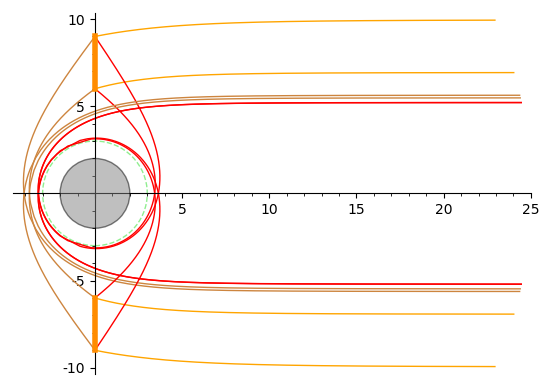

In [47]:
eps_L = 1
b = find_b(4*pi, r_em, phi_em, pre_periastron=em_pre_periastron)
graph += line(geod(r_em, phi_em, b, eps_L, em_pre_periastron=em_pre_periastron,
                   np=1000), color=color3)
graph

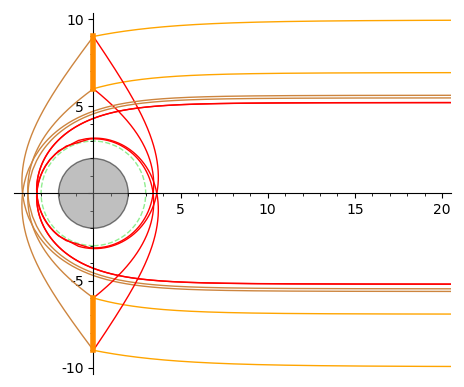

In [48]:
show(graph, xmax=20)

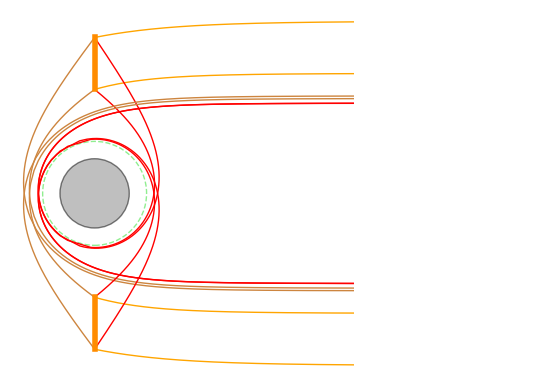

In [49]:
graph1 = graph + polygon([(15,-10), (15,10), (25,10), (25,-10)], color='white', 
                         zorder=100, axes=False)
graph1

In [50]:
graph1 += circle((25, 0), b1_out, color=color1, fill=True, zorder=101)
graph1 += circle((25, 0), b1_in, color='white', fill=True, thickness=0.1, zorder=102)

In [51]:
graph1 += circle((25, 0), b2_out, color=color2, fill=True, zorder=103)
graph1 += circle((25, 0), b2_in, color='white', fill=True, thickness=0.1, zorder=104)

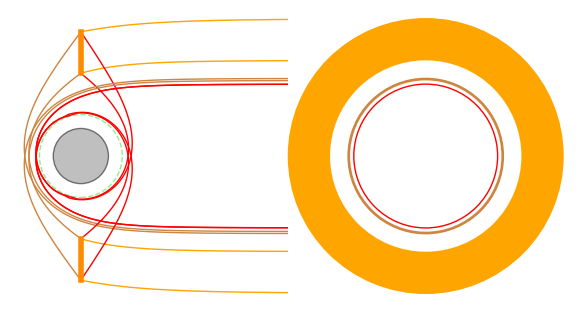

In [52]:
graph1 += circle((25, 0), b3_out, color=color3, zorder=105)
graph1

Slight reajustment to take into account that the null geodesics are cut at finite $r$:

In [53]:
a = 0.995
b1_in *= a
b1_out *= a
b2_in *= a
b2_out *= a
b3_in *= a
b3_out *= a

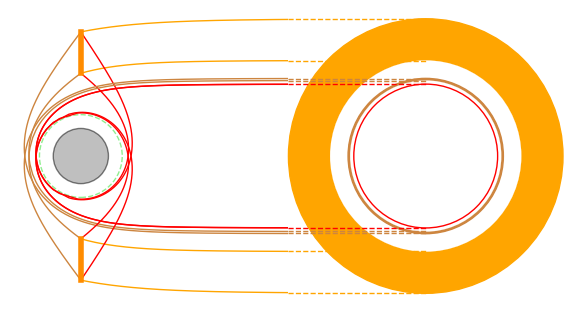

In [54]:
graph1 += line([(15, b1_out), (25, b1_out)], linestyle='dashed', 
               color=color1, zorder=106)
graph1 += line([(15, b1_in), (25, b1_in)], linestyle='dashed', 
               color=color1, zorder=107)
graph1 += line([(15, b2_out), (25, b2_out)], linestyle='dashed', 
               color=color2, zorder=108)
graph1 += line([(15, b2_in), (25, b2_in)], linestyle='dashed', 
               color=color2, zorder=109)
graph1 += line([(15, b3_out), (25, b3_out)], linestyle='dashed', 
               color=color3, zorder=110)
graph1 += line([(15, -b1_out), (25, -b1_out)], linestyle='dashed', 
               color=color1, zorder=106)
graph1 += line([(15, -b1_in), (25, -b1_in)], linestyle='dashed', 
               color=color1, zorder=107)
graph1 += line([(15, -b2_out), (25, -b2_out)], linestyle='dashed', 
               color=color2, zorder=108)
graph1 += line([(15, -b2_in), (25, -b2_in)], linestyle='dashed', 
               color=color2, zorder=109)
graph1 += line([(15, -b3_out), (25, -b3_out)], linestyle='dashed', 
               color=color3, zorder=110)
graph1

In [55]:
graph1.save("gis_disk_image.pdf")